In [44]:
from importlib import reload
import pymongo
import gridfs
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [48]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

import src.exp_utils as exp_utils
reload(exp_utils)

import src.losses as losses
reload(losses)

<module 'src.losses' from '/storage/781-piano-autoencoder/src/losses.py'>

In [ ]:
tf.compat.v1.disable_eager_execution()

In [14]:
run = 307
client = pymongo.MongoClient()  # assuming a local MongoDB
fs = gridfs.GridFS(client.sacred)  # assuming database name is 'sacred'
runs = client.sacred.runs
# Now get run from the database
run_entry = runs.find_one({'_id': run})
config = run_entry['config']

In [18]:
# get training data
model_datas_train, seconds1 = data.folder2examples('training_data/midi_train' + config['data_folder_prefix'], sparse=False,
                                                  use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                  nth_file=None, vel_cutoff=config['vel_cutoff'], sub_beats=config['sub_beats'])
model_datas_val, seconds2 = data.folder2examples('training_data/midi_val' + config['data_folder_prefix'], sparse=False,
                                                use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                sub_beats=config['sub_beats'])

100%|██████████| 230/230 [01:13<00:00,  3.13it/s]


10h 47m 55s of data
created model data H :    (32, 88) data shape,     4122 training examples
created model data O :    (32, 88) data shape,     4122 training examples
created model data V :    (32, 88) data shape,     4122 training examples
created model data R :    (32, 88) data shape,     4122 training examples
created model data S :    (32, 2) data shape,     4122 training examples
created model data key :    (12,) data shape,     4122 training examples
created model data tempo :    (1,) data shape,     4122 training examples


  8%|▊         | 1/12 [00:00<00:01,  7.82it/s]

created model data V_mean :    (1,) data shape,     4122 training examples


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

00h 38m 48s of data
created model data H :    (32, 88) data shape,     250 training examples
created model data O :    (32, 88) data shape,     250 training examples
created model data V :    (32, 88) data shape,     250 training examples
created model data R :    (32, 88) data shape,     250 training examples
created model data S :    (32, 2) data shape,     250 training examples
created model data key :    (12,) data shape,     250 training examples
created model data tempo :    (1,) data shape,     250 training examples
created model data V_mean :    (1,) data shape,     250 training examples


In [22]:
seconds2 / 3600

0.6467469894731687

In [ ]:
model_input_reqs, model_output_reqs = models.get_model_reqs(config['model_inputs'], config['model_outputs'])

config['beta_rate'] = 0

# model kwargs - for the encoder/decoder builder functions, make a dictionary to pass as kwargs
model_kwargs = config
# if variational, z will be a list of [[means], [stds]]
build_encoder_graph = models.create_LSTMencoder_graph
z, model_inputs_tf = build_encoder_graph(model_input_reqs, **model_kwargs)

if config['variational']:
    beta_fn = exp_utils.beta_fn2(config['beta_rate'], config['max_beta'])
    loss_for_train, beta_cb = losses.vae_custom_loss(z, beta_fn, free_bits=config['free_bits'], kl_weight=config['kl_weight'])
    sampling_fn = models.sampling(config['batch_size'], epsilon_std=config['epsilon_std'])
    # z_input is the tensor that will be passed into the decoder
    z_input = layers.Lambda(sampling_fn)(z)
else:
    loss_for_train = config['loss']
    z_input = z

if config['hierarchical']:
    build_decoder_graph = models.create_hierarchical_decoder_graph
else:
    build_decoder_graph =models.create_LSTMdecoder_graph_ar

pred, ar_inputs_tf = build_decoder_graph(z_input, model_output_reqs, **model_kwargs)
autoencoder = tf.keras.Model(inputs=model_inputs_tf + ar_inputs_tf, outputs=pred, name=f'autoencoder')
autoencoder.summary()


dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

dg_val = ml_classes.ModelDataGenerator([md for md in model_datas_val.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

In [ ]:
config
# config['loss_weights'][0]

In [ ]:
opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=opt, loss=loss_for_train, metrics=config['metrics'], loss_weights=config['loss_weights'])

In [ ]:
# autoencoder.load_weights(f'experiments/run_{run}/{run}_best_train_weights.hdf5', by_name=True)
models.load_weights_safe(autoencoder,f'experiments/run_{run}/{run}_best_val_weights.hdf5',by_name=False)

In [ ]:
random_examples, idx = data.n_rand_examples(model_datas_val, n=64)
random_examples['H_out'] = random_examples['H_ar']
random_examples['V_out'] = random_examples['V_ar']
autoencoder.evaluate(random_examples, random_examples, batch_size=config['batch_size'])

In [ ]:
def matrices2note_tuples(H, V):
    """given an example in HOV form, return note_tuples and velocities for notes
    
    Notes:
    experimental function... It is easier to just go straight to note_tuple like representation from pm.
    Won't use this one.
    """
    # this is in order: pitch from low to high for first beat, then for second...
    # note mask for selecting note positions
    note_mask = np.where(H != 0)
    # list of lists, each sublist is [pitch, timestep]
    note_tuples = [[pitch, timestep] for timestep, pitch in zip(note_mask[0], note_mask[1])]
    velocities = V[note_mask]
    return note_tuples, velocities

In [ ]:
# get training data
beats_per_ex = 16
sub_beats = 2
seq_length = beats_per_ex * sub_beats
model_datas_train, seconds = data.folder2examples('training_data/midi_train' + '_8', sparse=False,
                                                  beats_per_ex=beats_per_ex, nth_file=8, vel_cutoff=4, sub_beats=sub_beats)

In [ ]:
lengths = []
for i in range(len(model_datas_train['H'].data)):
    a, b = matrices2note_tuples(model_datas_train['H'].data[i], model_datas_train['V'].data[i])
    lengths.append(len(a))

In [ ]:
plt.hist(lengths, bins=20)

In [ ]:
sub_beat_len = .46
# time of note is closest to 5th subbeat
time = 5.3 * sub_beat_len
round(time / sub_beat_len)

In [ ]:
pm.instruments[0].notes[:10]

In [36]:
# testing model data generator for V_no_zeros
model_input_reqs, model_output_reqs = models.get_model_reqs(config['model_inputs'], config['model_outputs'])
dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'],
                                    V_no_zeros=False)


## Examining hyperparameters: plotting metrics from different training runs 

In [18]:
# establish connection to database
client = pymongo.MongoClient()
fs = gridfs.GridFS(client.sacred)
runs = client.sacred.runs
metrics = client.sacred.metrics

# determine which runs are needed
run_entries = list(runs.find({'_id': {'$in': [i for i in range(344, 400)]}}))
# metric_ids = {m['name']: ObjectId(m['id']) for m in run_entry['info']['metrics']}
df = pd.DataFrame()

# What is the hyperparameter of interst? (x axis)
x = 'loss_weights'
df[x] = [run['config'][x] for run in run_entries]

# stats where minimum is best, or maximum is best
min_stats = [k for k in run_entries[0]['info']['logs'].keys() if any(x in k for x in ['categ', 'loss', 'mse'])]
max_stats = [k for k in run_entries[0]['info']['logs'].keys() if any(x in k for x in ['acc'])]

for stat in min_stats:
    df[stat] =[min([step['value'] for step in run['info']['logs'][stat]]) for run in run_entries]
for stat in max_stats:
    df[stat] =[max([step['value'] for step in run['info']['logs'][stat]]) for run in run_entries]



In [14]:
'[1, 10]'.replace(']', ' ').split()[-1]

'10'

In [19]:
df['loss_weights'] = df['loss_weights'].apply(lambda x: x[-1])

In [20]:
### simple checkbox gui
# one checkbox per metric
checkboxes = [widgets.Checkbox(description=col,) for col in df.columns]
# plot button
button = widgets.Button(description='Plot')
# output of plotting
out = widgets.Output()
def on_button_click(_):
    """simple function for plotting ticked metrics on button click"""
    with out:
        # don't neglect to clear the output!
        clear_output()
        plot_metrics = [c.description for c in checkboxes if c.value]
        for m in plot_metrics:
            plt.plot(df.sort_values(x)[x], df[m], marker='o')
        plt.xscale('log')
        plt.legend(plot_metrics, loc='lower center')
        plt.show()
# linking button and function together using a button's method
button.on_click(on_button_click)
# displaying button and its output together
widgets.VBox(checkboxes + [button,out])

max_beta


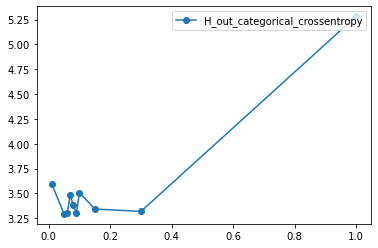

In [82]:
# box.children[0].value
print(box.children[0].description)
plot_metrics = [c.description for c in box.children if c.value]
for m in plot_metrics:
    plt.plot(df.sort_values('max_beta')['max_beta'], df[m], marker='o')
plt.legend(plot_metrics, loc='upper right')

In [44]:
batch_size = 2
sub_beats = 4
seq_length = 20
beats_sparse = [i // sub_beats % sub_beats for i in range(seq_length)]
# beats_sparse = [i % sub_beats for i in range(seq_length)]
beat_indicators = np.zeros((batch_size, seq_length, 4))
beat_indicators[:, [i for i in range(seq_length)], beats_sparse] = 1
# [i // sub_beats % sub_beats for i in range(seq_length)]
beat_indicators

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1

In [ ]:

model_datas_train, seconds = data.folder2examples('training_data/midi_train' + config['data_folder_prefix'], sparse=False,
                                                  use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                  nth_file=8, vel_cutoff=config['vel_cutoff'], sub_beats=config['sub_beats'])

In [6]:
models.get_model_reqs(model_inputs='all', model_outputs='all', sub_beats=2, seq_length=10)

None


In [9]:

n_notes=88
sub_beats=2
seq_length=50
model_input = namedtuple('input', 'name dim seq md ohe transposable') 
model_output = namedtuple('output', 'name dim activation seq md ohe transposable') 

# model input requirements
model_input_reqs_unfiltered = [
                            ### HOV inputs
                            model_input('H', n_notes, True, True, ohe=False, transposable=True),
                            model_input('tempo', 1, False, True, ohe=False, transposable=False),
                            model_input('key', 12, False, True, ohe=True, transposable=True),
                            model_input('V_mean', 1, False, True, ohe=False, transposable=False),
                            model_input('beat_indicators', 4, True, False, ohe=True, transposable=False),
                            model_input('sub_beat_indicators', sub_beats, True, False, ohe=True, transposable=False),

                            ### nbq inputs
                            model_input('TSn', seq_length, True, True, ohe=True, transposable=False), # note starts in sub beats
                            model_input('TEn', seq_length, True, True, ohe=True, transposable=False), # note ends in sub beats
                            model_input('TBn', 4, True, True, ohe=False, transposable=False), # note starts in beats of bar 
                            model_input('TSBn', sub_beats, True, True, ohe=True, transposable=False), # note starts in sub beats of beat
                            model_input('Pn', n_notes, True, True, ohe=True, transposable=True), # pitch
                            model_input('PCn', 12, True, True, ohe=True, transposable=True)] # pitch class

# model output requirements
model_output_reqs_unfiltered = [
                                ### HOV inputs
                                model_output('H', n_notes, 'sigmoid', True, True, ohe=False, transposable=True),
                                model_output('O', n_notes, 'tanh', True, True, ohe=False, transposable=True),
                                model_output('V', n_notes, 'sigmoid', True, True, ohe=False, transposable=True),

                                # nbq outputs
                                model_output('TEn', seq_length, 'softmax', True, True, ohe=True, transposable=False),
                                model_output('Vn', 1, 'sigmoid', True, True, ohe=False, transposable=False)]


print({m_input.name: m_input for m_input in model_input_reqs_unfiltered}.update({m_output.name: m_output for m_output in model_output_reqs_unfiltered}))


None


In [35]:
pm = pretty_midi.PrettyMIDI('training_data/midi_train_8/fp_110_Am.mid')
nbq = midi_utils.pm2nbq(pm, key='Am')
pm2 = data.nbq2pm({k: v[10] for k, v in nbq.items()})
pm2.write('nbqtest.mid')

In [69]:
model_datas_train, seconds = data.folder2nbq('training_data/midi_train' + '_8', 
                                            return_ModelData_object=True,
                                            seq_length=50, 
                                            sub_beats=2, 
                                            example_bars_skip=4, 
                                            use_base_key=False, 
                                            nth_file=15, 
                                            vel_cutoff=5)


100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

00h 43m 51s of data
created model data TSn :    (50,) data shape,     278 training examples
created model data TEn :    (50,) data shape,     278 training examples
created model data TBn :    (50, 4) data shape,     278 training examples
created model data TMn :    (50, 16) data shape,     278 training examples
created model data TSBn :    (50, 2) data shape,     278 training examples
created model data Pn :    (50, 88) data shape,     278 training examples
created model data PSn :    (50, 1) data shape,     278 training examples
created model data PCn :    (50, 12) data shape,     278 training examples
created model data Vn :    (50, 1) data shape,     278 training examples
created model data tempo :    (1,) data shape,     278 training examples
created model data key :    (12,) data shape,     278 training examples
created model data V_mean :    (1,) data shape,     278 training examples


In [40]:
model_inputs = ['Pn', 'TBn', 'TSBn']
model_outputs = ['Vn']
model_input_reqs, model_output_reqs = models.get_model_reqs(model_inputs, model_outputs, sub_beats=sub_beats)
dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                        [model_in.name for model_in in model_input_reqs if model_in.md],
                                        [model_out.name for model_out in model_output_reqs if model_out.md],
                                        t_force=True, batch_size = 64, seq_length=seq_length,
                                        sub_beats=sub_beats, V_no_zeros=False)

In [49]:
random_examples, idx = data.n_rand_examples(model_datas_train, n=64)

In [70]:
batch_size = 64
random_examples, idx = data.n_rand_examples(model_datas_train, n=batch_size)

# find axis that corresponds to velocity

model_datas_pred = copy.deepcopy(model_datas_train)
model_datas_pred['Vn'].data[idx,...] = 0.15
path = 'test2/'
os.mkdir(path + 'midi/')
for i in idx:
    mds_orig = {md.name: md.data[i] for k, md in model_datas_train.items()}
    mds_pred = {md.name: md.data[i] for k, md in model_datas_pred.items()}
    pm_original = data.nbq2pm(mds_orig)
    pm_pred = data.nbq2pm(mds_pred)
    pm_original.write(path + 'midi/' + f'ex{i}original.mid')
    pm_pred.write(path + 'midi/' + f'ex{i}prediction_teacher_forced.mid')

In [55]:
model_datas_val

{'H': <src.ml_classes.ModelData at 0x7f4f5a35e070>,
 'O': <src.ml_classes.ModelData at 0x7f4f5a35e220>,
 'V': <src.ml_classes.ModelData at 0x7f4f5a35e4c0>,
 'R': <src.ml_classes.ModelData at 0x7f4f5a35e580>,
 'S': <src.ml_classes.ModelData at 0x7f4f5a35e4f0>,
 'tempo': <src.ml_classes.ModelData at 0x7f4fc476c2e0>,
 'key': <src.ml_classes.ModelData at 0x7f4f5a35e550>,
 'V_mean': <src.ml_classes.ModelData at 0x7f4f5a35e0a0>}

In [65]:
[md for md in random_examples.keys()]

['dummy',
 'TSn_in',
 'TEn_in',
 'TBn_in',
 'TBn_ar',
 'TMn_in',
 'TMn_ar',
 'TSBn_in',
 'TSBn_ar',
 'Pn_in',
 'Pn_ar',
 'PSn_in',
 'PSn_ar',
 'PCn_in',
 'PCn_ar',
 'Vn_in',
 'Vn_ar',
 'tempo_in',
 'key_in',
 'V_mean_in']